In [1]:
import pandas as pd 
import os

raw_label_data = pd.read_csv('dataset_yidong/Day8_0-54.txt')
score_data = pd.read_csv('score_statistics.csv', header=None, names=['score']).astype(float)
print(raw_label_data.info())
print(score_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 3 columns):
machine_id    1998 non-null int64
kpi_id        1998 non-null int64
label         1998 non-null int64
dtypes: int64(3)
memory usage: 47.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 1 columns):
score    1998 non-null float64
dtypes: float64(1)
memory usage: 15.7 KB
None


In [2]:
'''
    打标签0正常，1子序列离群，2非周期性，3周期性;新数据只有0和1两种标签
'''
names = []
for i in range(54):
    for j in range(37):
        name = str(i) + '_' + str(j)
        names.append(name)

real_scores = score_data['score'].tolist()
real_scores = [float(score) if score<1 else 0.99 for score in real_scores]
print(len(real_scores))

raw_labels = []
for i in raw_label_data['label'].tolist():
    raw_labels.append(1 - i)

score_label = pd.DataFrame({'name': names, 'score': real_scores, 'label_raw': raw_labels})
score_label.to_csv('./score_label.csv', index=None)

1998


In [3]:
'''
    计算最佳score，保存pr和re；0是正常，1是异常
'''
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import pandas as pd

evaluate_data = pd.read_csv('./score_label.csv')
score = evaluate_data['score'].tolist()
label = evaluate_data['label_raw'].tolist()

precision, recall, thresholds = precision_recall_curve(label, score, pos_label=1)
f1_record = 0
index = 0

for i in range(len(thresholds)):
    if precision[i] == 0 or recall[i] == 0:
        continue
    f1 = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    if f1 > f1_record:
        f1_record = f1
        index = i
print("best threshold: ", thresholds[index])
print("best precision: ", precision[index])
print("best recall: ", recall[index])
print("best f1_score: ", f1_record)

#将个数对齐
print((len(precision), len(recall), len(thresholds)))
precision = precision[:-1]
recall = recall[:-1]
fscores = []
for i in range(len(precision)):
    fscore = 2*precision[i]*recall[i] / (precision[i]+recall[i])
    fscores.append(fscore)
print((len(precision), len(recall), len(thresholds), len(fscores)))


pr_dict = {
    'precision': precision,
    'recall': recall,
    'fscore': fscores,
    'thresholds': thresholds,
}
pr_data = pd.DataFrame(pr_dict)
pr_data.to_csv('./pr_evaluate.csv', index=None)


best threshold:  0.15024714513882695
best precision:  0.07001414427157002
best recall:  0.99
best f1_score:  0.130779392338177
(585, 585, 584)
(584, 584, 584, 584)


In [4]:
'''
    计算AUC,保存fpr和tpr；0是正常，1是异常
'''
fpr, tpr, th = roc_curve(label, score, pos_label=1)
auc_record = auc(fpr, tpr)
print('AUC: ', auc_record)

print((len(fpr), len(tpr), len(th)))

roc_dict = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': th
}
roc_data = pd.DataFrame(roc_dict)
roc_data.to_csv('./roc_evaluate.csv', index=None)

AUC:  0.6287723919915701
(155, 155, 155)


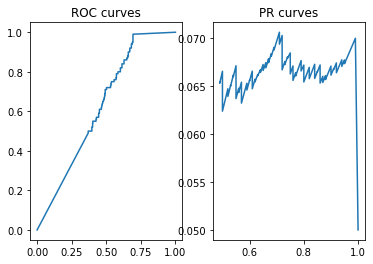

In [5]:
'''
    绘制ROC和PR曲线
'''
import matplotlib.pyplot as plt 

#ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr)
plt.title('ROC curves')

#PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.title('PR curves')

plt.savefig(os.path.join('./images', 'curve.png'))
plt.show()
